In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `C:\Users\okarl\Desktop\diploma-thesis\ntbks`


In [2]:
using Plots
using StatsPlots
using JLD
using Statistics
using DataFrames
using ColorSchemes
using LaTeXStrings

In [3]:
DATA_PATH = "../results/"

function load_results(path, n_pars; bayes=false, adjusted=false)
    files = readdir(path)

    results = zeros(length(files), n_pars, 5)
    total_sims = 0

    for i in axes(files)[1]
        data = load(path * files[i])
        
        total_sims += sum(data["total_sims"])

        if adjusted
            data = data["adjusted_particles"]
        elseif bayes
            data = data["particles"]
        else
            data = data["parameters"]
        end

        # mean
        results[i, :, 1] = mean(data, dims=2)
        # median
        results[i, :, 2] = median(data, dims=2)
        # std
        results[i, :, 3] = std(data, dims=2)

        # credible interval/confidence interval
        results[i, :, 4] = hcat([quantile(data[i, :], 0.025) for i in 1:size(data, 1)]) # lower
        results[i, :, 5] = hcat([quantile(data[i, :], 0.975) for i in 1:size(data, 1)]) # upper
    end

    total_sims /= length(files)
    println(total_sims)
    return results
end;


function RMSE(true_params, parameters, stds)
    true_params = reshape(true_params, ((1, size(true_params)[1])))
    return mean(sqrt.(((parameters .- true_params).^2 + stds.^2) ./ abs.(true_params)))
end;

# FW5p small noise

phi = 0.12  
chi = 1.50  
alpha_0 = -0.327  
alpha_n = 1.79  
alpha_p = 18.43  

In [4]:
TRUE_VALUES_5P = [0.12, 1.50, -0.327, 1.79, 18.43];

In [5]:
print("ABC: ")
fw5p_abc = load_results(DATA_PATH * "result_abc/fw5p_small_abc/", 5, bayes=true, adjusted=false)
print("Bayes: ")
fw5p_bayes = load_results(DATA_PATH * "result_bayes/fw5p_small_bayes/", 5, bayes=true)
print("SMM: ")
fw5p_smm = load_results(DATA_PATH * "result_smm/fw5p_small_smm/", 5)
print("NPMSLE: ")
fw5p_npmsle = load_results(DATA_PATH * "result_npmsle/fw5p_small_npmsle/", 5);

ABC: 371363.81
Bayes: 300000.0
SMM: 384096.0
NPMSLE: 384096.0


In [6]:
index_level_1 = ["True", "Mean", "Mean", "Mean", "Mean", "Median", "Median", "Median", "Median", "Lower", "Upper", "Lower", "Upper", "Lower", "Upper", "Lower", "Upper", "Std", "Std", "Std", "Std"]
index_level_2 = ["True", "SMM", "NPMSL", "ABC", "Bayes", "SMM", "NPMSL", "ABC", "Bayes", "SMM", "SMM", "NPMSL", "NPMSL", "ABC", "ABC", "Bayes", "Bayes", "SMM", "NPMSL", "ABC", "Bayes"]


column_values = zeros(length(index_level_1), 5)
column_values[1, :] = TRUE_VALUES_5P

for (i, data) in enumerate([fw5p_smm, fw5p_npmsle, fw5p_abc, fw5p_bayes])
    temp = round.(mean(data, dims=1)[1, :, :], digits=4)

    index = i + 1
    column_values[index, :] = temp[:, 1] # mean
    column_values[index + 4, :] = temp[:, 2] # median
    column_values[index + 8 + i - 1, :] = temp[:, 4] # lower
    column_values[index + 9 + i - 1, :] = temp[:, 5] # upper
    column_values[index + 16, :] = temp[:, 3] # std   
end

fw5p_df = DataFrame(Index1=index_level_1, Index2=index_level_2, Phi=column_values[:, 1], Chi=column_values[:, 2], Alpha_0=column_values[:, 3], 
                    Alpha_n=column_values[:, 4], Alpha_p=column_values[:, 5]);

In [7]:
rmse_smm_mean = RMSE(TRUE_VALUES_5P, mean(fw5p_smm[:, :, 1], dims=1), std(fw5p_smm[:, :, 1], dims=1))
rmse_smm_med = RMSE(TRUE_VALUES_5P, mean(fw5p_smm[:, :, 2], dims=1), std(fw5p_smm[:, :, 2], dims=1))

rmse_npmsle_mean = RMSE(TRUE_VALUES_5P, mean(fw5p_npmsle[:, :, 1], dims=1), std(fw5p_npmsle[:, :, 1], dims=1))
rmse_npmsle_med = RMSE(TRUE_VALUES_5P, mean(fw5p_npmsle[:, :, 2], dims=1), std(fw5p_npmsle[:, :, 2], dims=1))

rmse_abc_mean = RMSE(TRUE_VALUES_5P, mean(fw5p_abc[:, :, 1], dims=1), std(fw5p_abc[:, :, 1], dims=1))
rmse_abc_med = RMSE(TRUE_VALUES_5P, mean(fw5p_abc[:, :, 2], dims=1), std(fw5p_abc[:, :, 2], dims=1));

rmse_bayes_mean = RMSE(TRUE_VALUES_5P, mean(fw5p_bayes[:, :, 1], dims=1), std(fw5p_bayes[:, :, 1], dims=1))
rmse_bayes_med = RMSE(TRUE_VALUES_5P, mean(fw5p_bayes[:, :, 2], dims=1), std(fw5p_bayes[:, :, 2], dims=1));

In [8]:
palette = cgrad(:Set1_4, 4, categorical=true).colors

p1_mean = density(fw5p_smm[:, 1, 1], label="SMM", color=palette[1], linewidth=1.5, legendfontsize=12)
density!(p1_mean, fw5p_npmsle[:, 1, 1], label="NMSLE", color=palette[2], linewidth=1.5)
density!(p1_mean, fw5p_abc[:, 1, 1], label="ABC", color=palette[3], linewidth=1.5)
density!(p1_mean, fw5p_bayes[:, 1, 1], label="Bayes", color=palette[4], linewidth=1.5)
plot!(p1_mean, [TRUE_VALUES_5P[1]], seriestype="vline", label="True", color="black", linewidth=2.5)
title!(p1_mean, L"\phi", titlefontsize=24)

p2_mean = density(fw5p_smm[:, 2, 1], label="SMM", color=palette[1], linewidth=1.5, legendfontsize=12)
density!(p2_mean, fw5p_npmsle[:, 2, 1], label="NMSLE", color=palette[2], linewidth=1.5)
density!(p2_mean, fw5p_abc[:, 2, 1], label="ABC", color=palette[3], linewidth=1.5)
density!(p2_mean, fw5p_bayes[:, 2, 1], label="Bayes", color=palette[4], linewidth=1.5)
plot!(p2_mean, [TRUE_VALUES_5P[2]], seriestype="vline", label="True", color="black", linewidth=2.5)
title!(p2_mean, L"\chi", titlefontsize=24)

p3_mean = density(fw5p_smm[:, 3, 1], label="SMM", color=palette[1], linewidth=1.5, legendfontsize=12)
density!(p3_mean, fw5p_npmsle[:, 3, 1], label="NMSLE", color=palette[2], linewidth=1.5)
density!(p3_mean, fw5p_abc[:, 3, 1], label="ABC", color=palette[3], linewidth=1.5)
density!(p3_mean, fw5p_bayes[:, 3, 1], label="Bayes", color=palette[4], linewidth=1.5)
plot!(p3_mean, [TRUE_VALUES_5P[3]], seriestype="vline", label="True", color="black", linewidth=2.5)
title!(p3_mean, L"\alpha_0", titlefontsize=24)

p4_mean = density(fw5p_smm[:, 4, 1], label="SMM", color=palette[1], linewidth=1.5, legendfontsize=12)
density!(p4_mean, fw5p_npmsle[:, 4, 1], label="NMSLE", color=palette[2], linewidth=1.5)
density!(p4_mean, fw5p_abc[:, 4, 1], label="ABC", color=palette[3], linewidth=1.5)
density!(p4_mean, fw5p_bayes[:, 4, 1], label="Bayes", color=palette[4], linewidth=1.5)
plot!(p4_mean, [TRUE_VALUES_5P[4]], seriestype="vline", label="True", color="black", linewidth=2.5)
title!(p4_mean, L"\alpha_n", titlefontsize=24)

p5_mean = density(fw5p_smm[:, 5, 1], label="SMM", color=palette[1], linewidth=1.5, legendfontsize=12)
density!(p5_mean, fw5p_npmsle[:, 5, 1], label="NMSLE", color=palette[2], linewidth=1.5)
density!(p5_mean, fw5p_abc[:, 5, 1], label="ABC", color=palette[3], linewidth=1.5)
density!(p5_mean, fw5p_bayes[:, 5, 1], label="Bayes", color=palette[4], linewidth=1.5)
plot!(p5_mean, [TRUE_VALUES_5P[5]], seriestype="vline", label="True", color="black", linewidth=2.5)
title!(p5_mean, L"\alpha_p", titlefontsize=24)

plot_layout = (3, 2)
plot_5p_mean =plot(p1_mean, p2_mean, p3_mean, p4_mean, p5_mean,
    layout = plot_layout, leftmargin=6Plots.mm,
    legend=true, size=(900,1600)
);


p1_med = density(fw5p_smm[:, 1, 2], label="SMM", color=palette[1], linewidth=1.5, legendfontsize=12)
density!(p1_med, fw5p_npmsle[:, 1, 2], label="NPMSLE", color=palette[2], linewidth=1.5)
density!(p1_med, fw5p_abc[:, 1, 2], label="ABC", color=palette[3], linewidth=1.5)
density!(p1_med, fw5p_bayes[:, 1, 2], label="Bayes", color=palette[4], linewidth=1.5)
plot!(p1_med, [TRUE_VALUES_5P[1]], seriestype="vline", label="True", color="black", linewidth=2.5)
title!(p1_med, L"\phi", titlefontsize=24)

p2_med = density(fw5p_smm[:, 2, 2], label="SMM", color=palette[1], linewidth=1.5, legendfontsize=12)
density!(p2_med, fw5p_npmsle[:, 2, 2], label="NPMSLE", color=palette[2], linewidth=1.5)
density!(p2_med, fw5p_abc[:, 2, 2], label="ABC", color=palette[3], linewidth=1.5)
density!(p2_med, fw5p_bayes[:, 2, 2], label="Bayes", color=palette[4], linewidth=1.5)
plot!(p2_med, [TRUE_VALUES_5P[2]], seriestype="vline", label="True", color="black", linewidth=2.5)
title!(p2_med, L"\chi", titlefontsize=24)

p3_med = density(fw5p_smm[:, 3, 2], label="SMM", color=palette[1], linewidth=1.5, legendfontsize=12)
density!(p3_med, fw5p_npmsle[:, 3, 2], label="NPMSLE", color=palette[2], linewidth=1.5)
density!(p3_med, fw5p_abc[:, 3, 2], label="ABC", color=palette[3], linewidth=1.5)
density!(p3_med, fw5p_bayes[:, 3, 2], label="Bayes", color=palette[4], linewidth=1.5)
plot!(p3_med, [TRUE_VALUES_5P[3]], seriestype="vline", label="True", color="black", linewidth=2.5)
title!(p3_med, L"\alpha_0", titlefontsize=24)

p4_med = density(fw5p_smm[:, 4, 2], label="SMM", color=palette[1], linewidth=1.5, legendfontsize=12)
density!(p4_med, fw5p_npmsle[:, 4, 2], label="NPMSLE", color=palette[2], linewidth=1.5)
density!(p4_med, fw5p_abc[:, 4, 2], label="ABC", color=palette[3], linewidth=1.5)
density!(p4_med, fw5p_bayes[:, 4, 2], label="Bayes", color=palette[4], linewidth=1.5)
plot!(p4_med, [TRUE_VALUES_5P[4]], seriestype="vline", label="True", color="black", linewidth=2.5)
title!(p4_med, L"\alpha_n", titlefontsize=24)

p5_med = density(fw5p_smm[:, 5, 2], label="SMM", color=palette[1], linewidth=1.5, legendfontsize=12)
density!(p5_med, fw5p_npmsle[:, 5, 2], label="NPMSLE", color=palette[2], linewidth=1.5)
density!(p5_med, fw5p_abc[:, 5, 2], label="ABC", color=palette[3], linewidth=1.5)
density!(p5_med, fw5p_bayes[:, 5, 2], label="Bayes", color=palette[4], linewidth=1.5)
plot!(p5_med, [TRUE_VALUES_5P[5]], seriestype="vline", label="True", color="black", linewidth=2.5)
title!(p5_med, L"\alpha_p", titlefontsize=24)

plot_layout = (3, 2)
plot_5p_med =plot(p1_med, p2_med, p3_med, p4_med, p5_med,
    layout = plot_layout, leftmargin=6Plots.mm,
    legend=true, size=(900,1600)
);

In [9]:
println(fw5p_df)

21×7 DataFrame
 Row │ Index1  Index2  Phi      Chi      Alpha_0  Alpha_n  Alpha_p 
     │ String  String  Float64  Float64  Float64  Float64  Float64 
─────┼─────────────────────────────────────────────────────────────
   1 │ True    True     0.12     1.5     -0.327    1.79    18.43
   2 │ Mean    SMM      0.7451   1.5273  -0.4549   1.5082  32.8266
   3 │ Mean    NPMSL    0.2238   1.4886  -0.5335   1.5101  40.9245
   4 │ Mean    ABC      0.8038   1.4994  -0.4145   1.575   30.375
   5 │ Mean    Bayes    0.292    1.5481  -0.4604   1.6048  36.4523
   6 │ Median  SMM      0.7419   1.5267  -0.4584   1.5007  33.1346
   7 │ Median  NPMSL    0.2041   1.4885  -0.5373   1.5219  42.6114
   8 │ Median  ABC      0.7747   1.5047  -0.4154   1.5743  30.3963
   9 │ Median  Bayes    0.2729   1.5619  -0.4594   1.6199  37.5942
  10 │ Lower   SMM      0.3488   0.7726  -0.668    1.1651  17.7747
  11 │ Upper   SMM      1.1669   2.2514  -0.2295   1.8702  46.6183
  12 │ Lower   NPMSL    0.0316   0.1594  -0.830

In [10]:
println("Mean parameters RMSE")
println("SMM:     $rmse_smm_mean")
println("NMSLE:   $rmse_npmsle_mean")
println("ABC:     $rmse_abc_mean")
println("Bayes:   $rmse_bayes_mean")
println()
println("Median parameters RMSE")
println("SMM:     $rmse_smm_med")
println("NMSLE:   $rmse_npmsle_med")
println("ABC:     $rmse_abc_med")
println("Bayes:   $rmse_bayes_med")

Mean parameters RMSE
SMM:     1.7823413529528445
NMSLE:   1.4614101289679808
ABC:     1.5790037548198224
Bayes:   1.2843682872119693

Median parameters RMSE
SMM:     1.8694155054735972
NMSLE:   1.5704771084267002
ABC:     1.662029628304636
Bayes:   1.3810707038496874


### Mean parameters

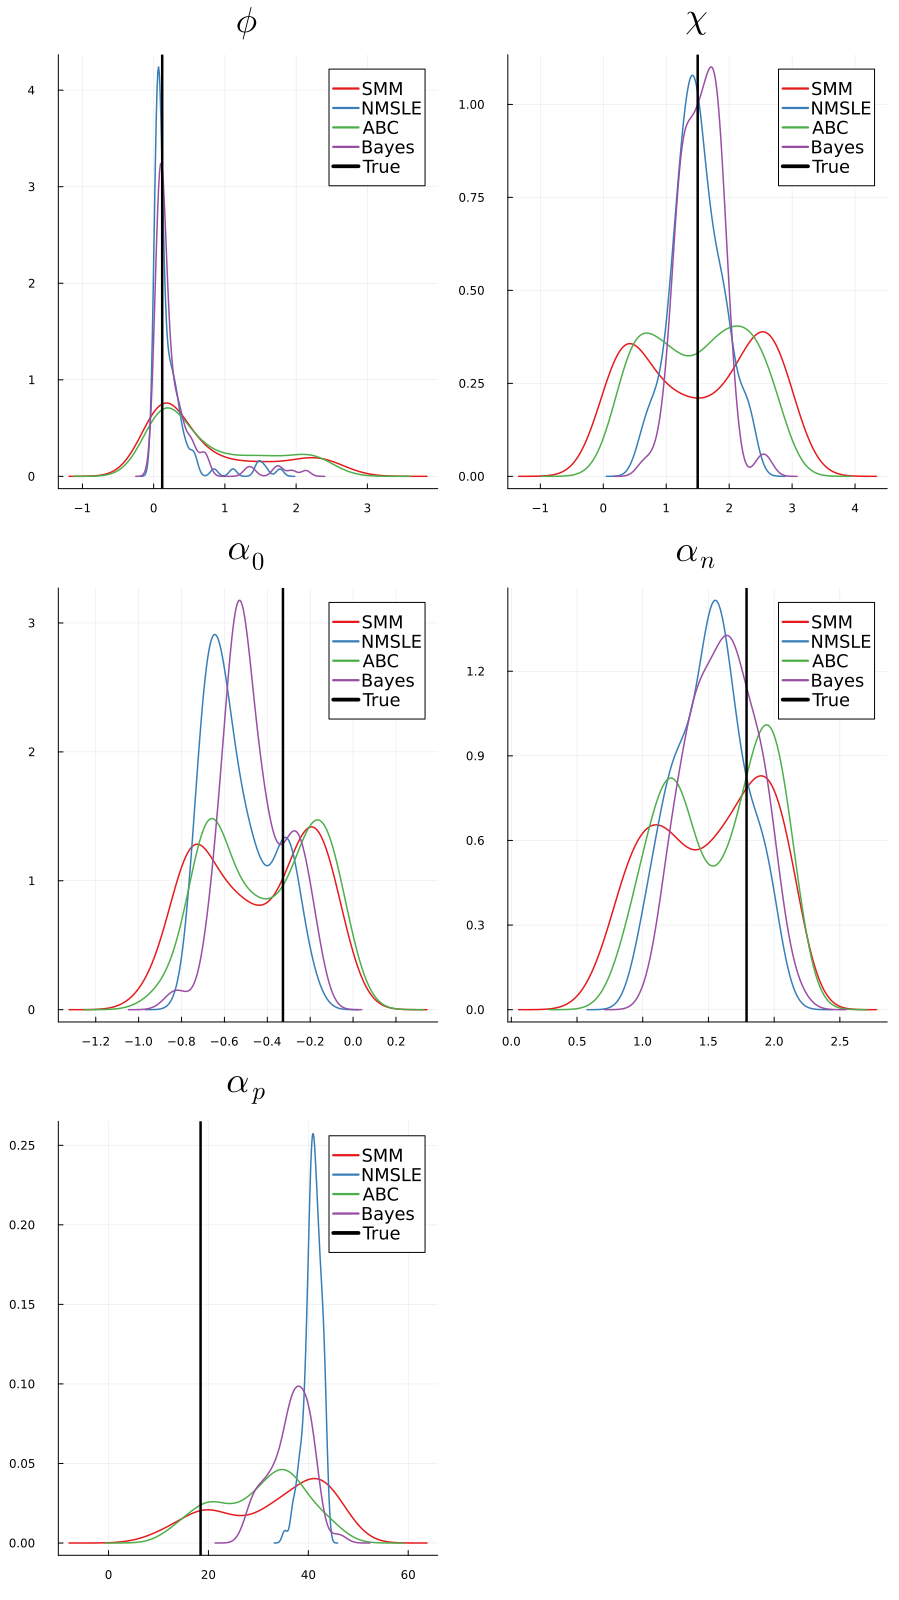

In [11]:
plot_5p_mean

### Median parameters

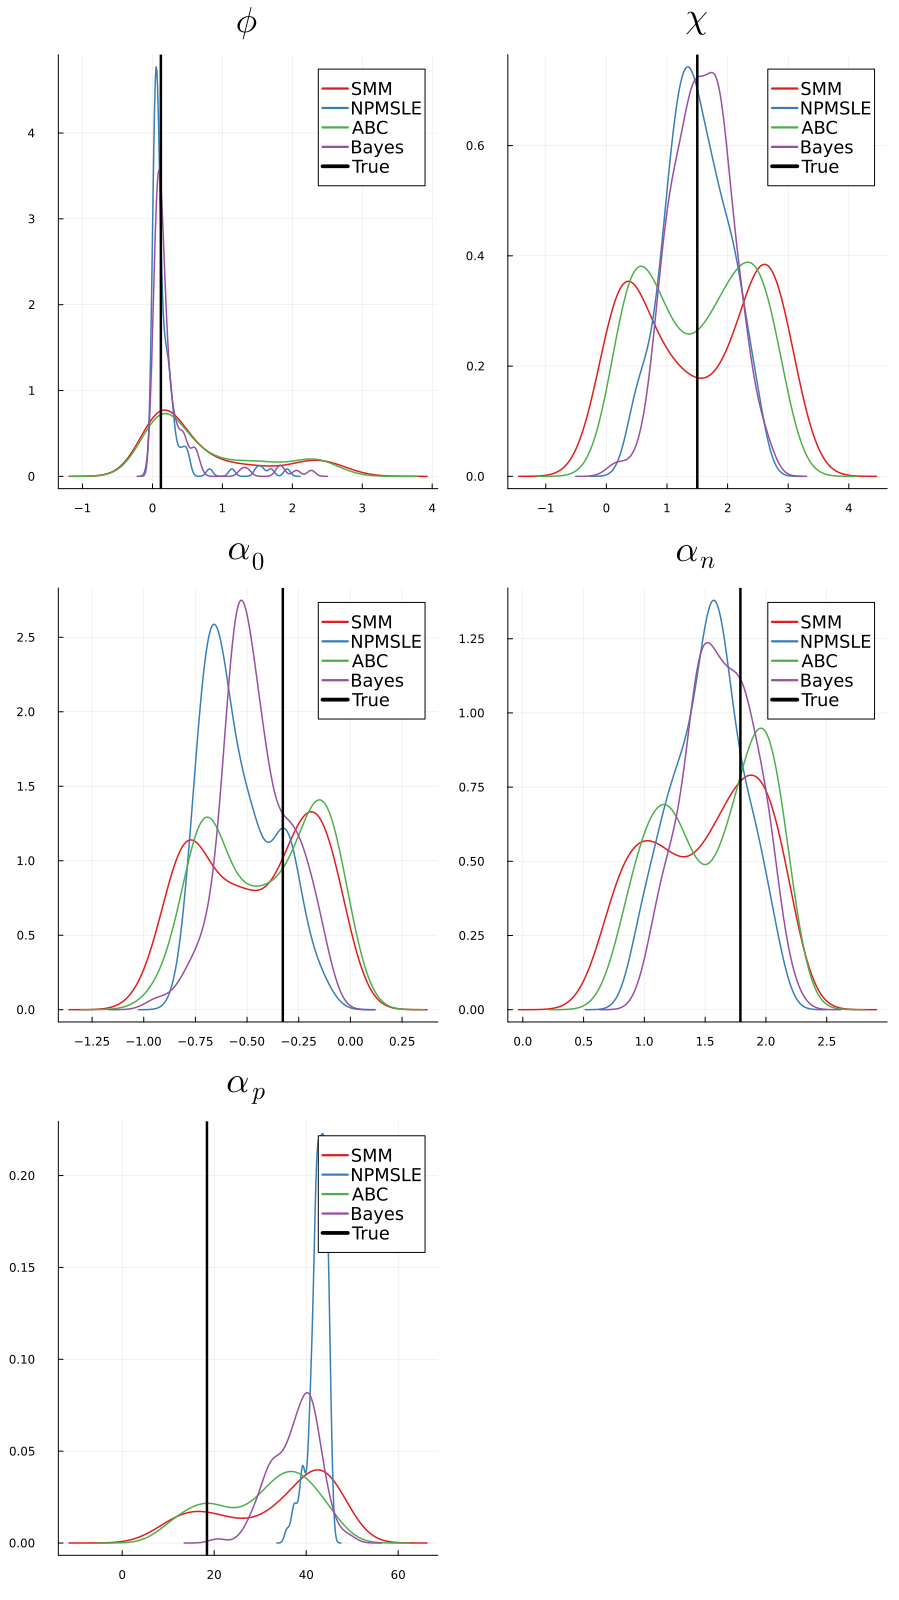

In [12]:
plot_5p_med